Source: 
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0196391

**File naming convention**
```
Each of the 7356 RAVDESS files has a unique filename. 
The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4).
These identifiers define the stimulus characteristics: 

+ Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
+ Vocal channel (01 = speech, 02 = song).
+ Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = + angry, 06 = fearful, 07 = disgust, 08 = surprised).
+ Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
+ Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
+ Repetition (01 = 1st repetition, 02 = 2nd repetition).
+ Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
```

In [ ]:
!wget https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip > /dev/null
!wget https://zenodo.org/record/1188976/files/Audio_Song_Actors_01-24.zip > /dev/null
!unzip Audio_Speech_Actors_01-24.zip -d Audio_Speech_Actors_01-24/ > /dev/null
!unzip Audio_Song_Actors_01-24.zip -d Audio_Song_Actors_01-24/ > /dev/null
!mkdir ravdess_16k
!mkdir ravdess_16k/audio

--2021-09-13 10:11:45--  https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208468073 (199M) [application/octet-stream]
Saving to: ‘Audio_Speech_Actors_01-24.zip’

Audio_Speech_Actors 100%[===================>] 198.81M  17.8MB/s    in 12s     

2021-09-13 10:11:59 (16.4 MB/s) - ‘Audio_Speech_Actors_01-24.zip’ saved [208468073/208468073]

--2021-09-13 10:11:59--  https://zenodo.org/record/1188976/files/Audio_Song_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225505317 (215M) [application/octet-stream]
Saving to: ‘Audio_Song_Actors_01-24.zip’

Audio_Song_Actors_0 100%[===================>] 215.06M  14.2MB/s    in 21s     

2021-09-13 10:12:21 (10.3 M

In [ ]:
!pip install torchaudio==0.9.0 > /dev/null

In [ ]:
import torchaudio
torchaudio.set_audio_backend('sox_io')
import IPython.display as ipd
from glob import glob
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import GroupKFold

In [ ]:
TARGET_SAMPLE_RATE = 16000

In [ ]:
waveform, sr = torchaudio.load('Audio_Song_Actors_01-24/Actor_01/03-02-01-01-01-01-01.wav')
ipd.Audio(waveform, rate=sr)

In [ ]:
waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SAMPLE_RATE)(waveform)
ipd.Audio(waveform, rate=TARGET_SAMPLE_RATE)

In [ ]:
len(glob('*/Actor_*/*.wav'))

2452

In [ ]:
emotion_mapping = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised',
}

dataset = []
for audio_path in tqdm(glob('*/Actor_*/*.wav')):
    audio_name = audio_path.split('/')[-1]
    _, vocal_channel, emotion, _, statement, _, actor_id = audio_name[:-4].split('-')

    waveform, sr = torchaudio.load(audio_path)
    waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=TARGET_SAMPLE_RATE)(waveform)
    torchaudio.save(f'ravdess_16k/audio/{audio_name}', waveform, TARGET_SAMPLE_RATE)

    dataset.append({
        'audio_name': audio_name,
        'vocal_channel': vocal_channel,
        'emotion': emotion_mapping[emotion],
        'statement': statement,
        'actor_id': actor_id,
        'label': int(emotion) - 1,
        'duration': round(waveform.shape[1] / TARGET_SAMPLE_RATE, 2)
    })

df = pd.DataFrame(dataset)

gkf = GroupKFold(n_splits=6)
df['stage'] = 'train'
train_index, valid_index = next(gkf.split(df.index, df['label'], df['actor_id']))
df.loc[valid_index, 'stage'] = 'valid'

df.to_csv('ravdess_16k/marking.csv', index=False)

df.head()

100%|██████████| 2452/2452 [00:12<00:00, 193.27it/s]


,audio_name,vocal_channel,emotion,statement,actor_id,label,duration,stage
0,03-01-02-02-01-01-06.wav,01,calm,01,06,1,4.50,valid
1,03-01-04-01-01-01-06.wav,01,sad,01,06,3,3.57,valid
2,03-01-04-02-01-02-06.wav,01,sad,01,06,3,4.10,valid
3,03-01-05-01-01-01-06.wav,01,angry,01,06,4,3.77,valid
4,03-01-01-01-01-02-06.wav,01,neutral,01,06,0,3.60,valid


In [ ]:
df['label'].value_counts(normalize=True)

5    0.153344
3    0.153344
1    0.153344
4    0.153344
2    0.153344
7    0.078303
6    0.078303
0    0.076672
Name: label, dtype: float64

In [ ]:
df[df['stage'] == 'train']['label'].value_counts(normalize=True)

5    0.153242
4    0.153242
3    0.153242
2    0.153242
1    0.153242
7    0.078585
6    0.078585
0    0.076621
Name: label, dtype: float64

In [ ]:
df[df['stage'] == 'valid']['label'].value_counts(normalize=True)

5    0.153846
4    0.153846
3    0.153846
2    0.153846
1    0.153846
7    0.076923
6    0.076923
0    0.076923
Name: label, dtype: float64

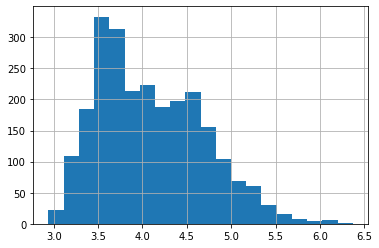

In [ ]:
df['duration'].hist(bins=20);

In [ ]:
!tar -czvf ravdess_16k.tar.gz ravdess_16k > /dev/null